# L3: Image generation app 🎨

In this lesson, we're going to build an image generation app with an open-source text-to-image model that takes a description and generates an image with it. Let's do that! The Image Generation Model is a diffusion model called Stable Diffusion, and we're connecting to this model on a server using an API URL. So here, we set up our API key.

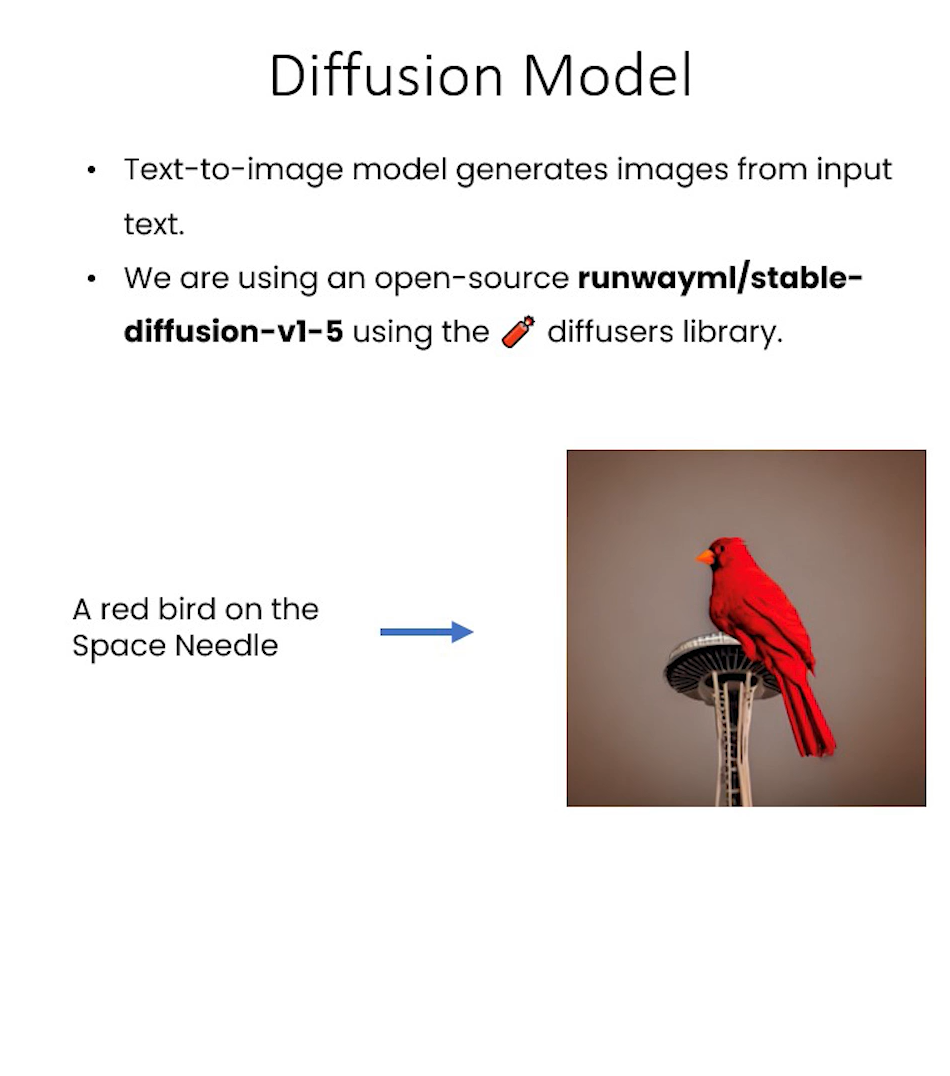

Load your HF API key and relevant Python libraries

In [ ]:
import os
import io
import IPython.display
from PIL import Image
import base64 
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
hf_api_key = os.environ['HF_API_KEY']

In [ ]:
# Helper function
import requests, json

#Text-to-image endpoint
def get_completion(inputs, parameters=None, ENDPOINT_URL=os.environ['HF_API_TTI_BASE']):
    headers = {
      "Authorization": f"Bearer {hf_api_key}",
      "Content-Type": "application/json"
    }   
    data = { "inputs": inputs }
    if parameters is not None:
        data.update({"parameters": parameters})
    response = requests.request("POST",
                                ENDPOINT_URL,
                                headers=headers,
                                data=json.dumps(data))
    return json.loads(response.content.decode("utf-8"))

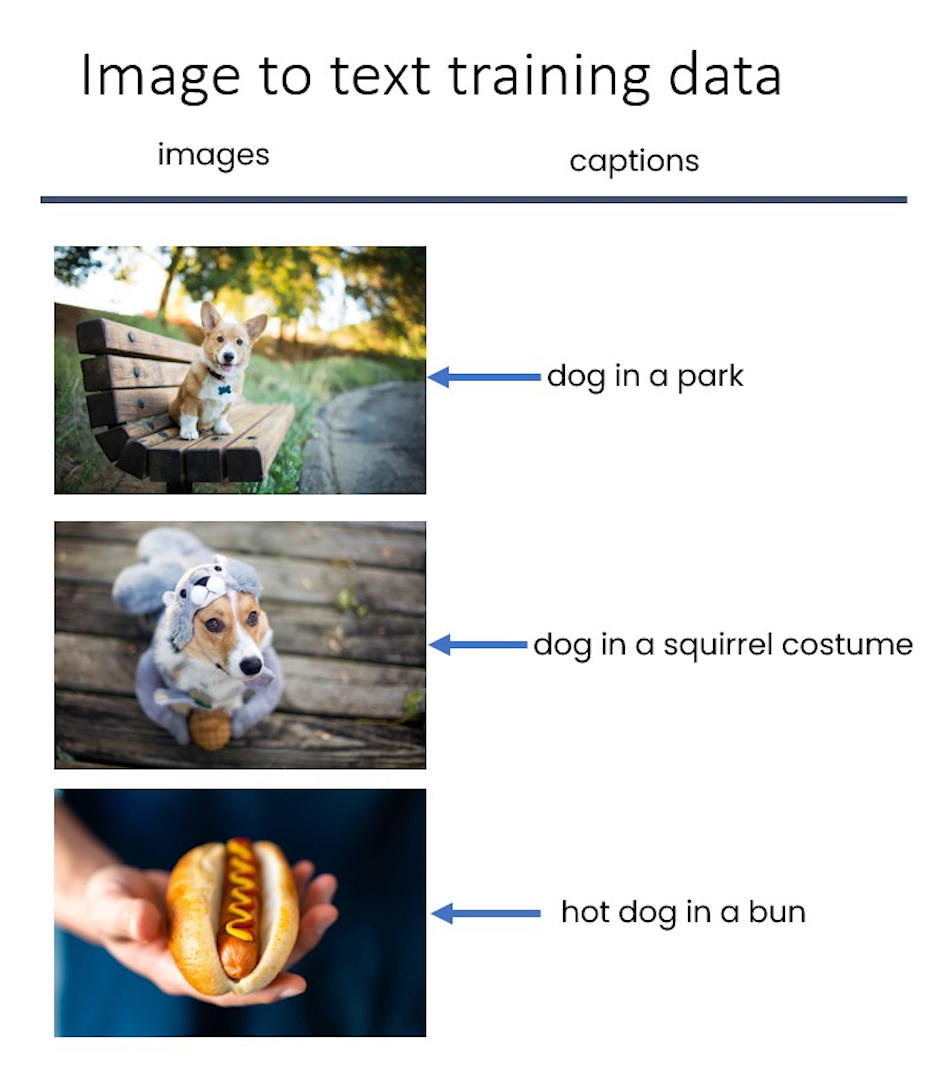

Here, we have our Get-Completion function. This time, it is a text-to-image endpoint. So in a previous lesson, we had an image-to-text endpoint. So basically, we had a model that would take an image and output a text that describes it. Here, we have a model that was trained to do the opposite. So, it was trained with the same subset of items. It was trained with an image and the text that describes it, but this time with the reverse objective. It was trained to get a description or a text and generate the image that would be associated with it.

## Building an image generation app 

Here we are going to run `runwayml/stable-diffusion-v1-5` using the `🧨 diffusers` library.

### How about running it locally?
The code would look very similar if you were running it locally instead of from an API.
```py
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

def get_completion(prompt):
    return pipeline(prompt).images[0]    
```

In [ ]:
prompt = "a dog in a park"

result = get_completion(prompt)
IPython.display.HTML(f'<img src="data:image/png;base64,{result}" />')

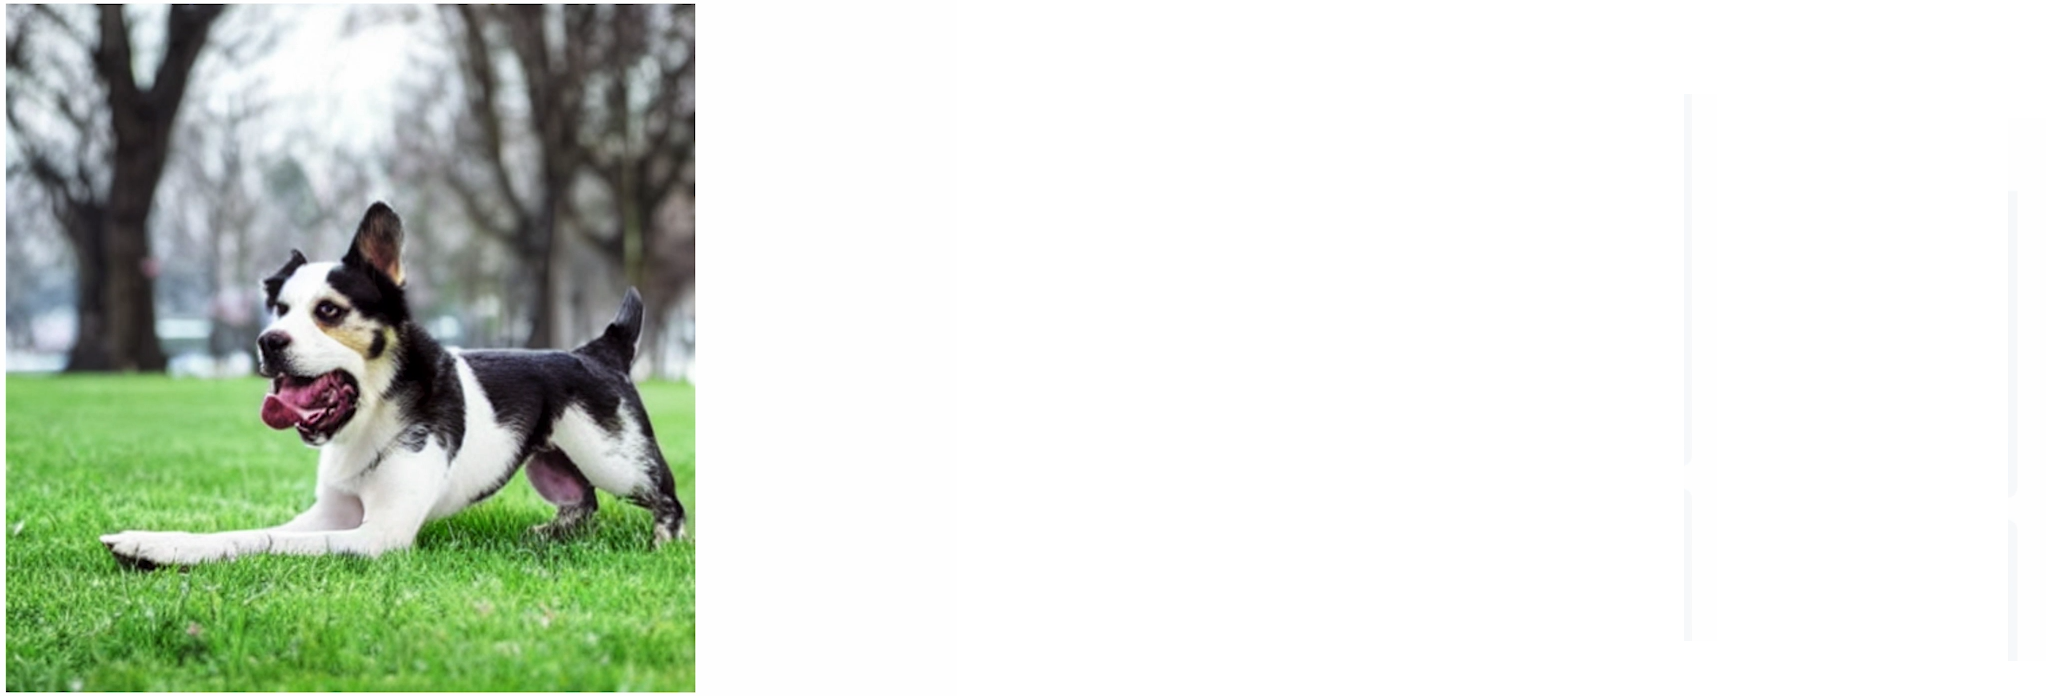

So, let's test it out. All right, it works! So, I can see from our text, a nice image was generated.

## Generating with `gr.Interface()`


So, let's build a Gradio app for this. So here, we have our Gradio app. We have our helper functions like before for helping with the API. Locally, we wouldn't need that. And we have a generate function and this time it's doing the opposite. So, it's taking the prompt and then it's resulting in an image.



In [ ]:
import gradio as gr 

#A helper function to convert the PIL image to base64
#so you can send it to the API
def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt):
    output = get_completion(prompt)
    result_image = base64_to_pil(output)
    return result_image

gr.close_all()
demo = gr.Interface(fn=generate,
                    inputs=[gr.Textbox(label="Your prompt")],
                    outputs=[gr.Image(label="Result")],
                    title="Image Generation with Stable Diffusion",
                    description="Generate any image with Stable Diffusion",
                    allow_flagging="never",
                    examples=["the spirit of a tamagotchi wandering in the city of Vienna","a mecha robot in a favela"])

demo.launch(share=True, server_port=int(os.environ['PORT1']))

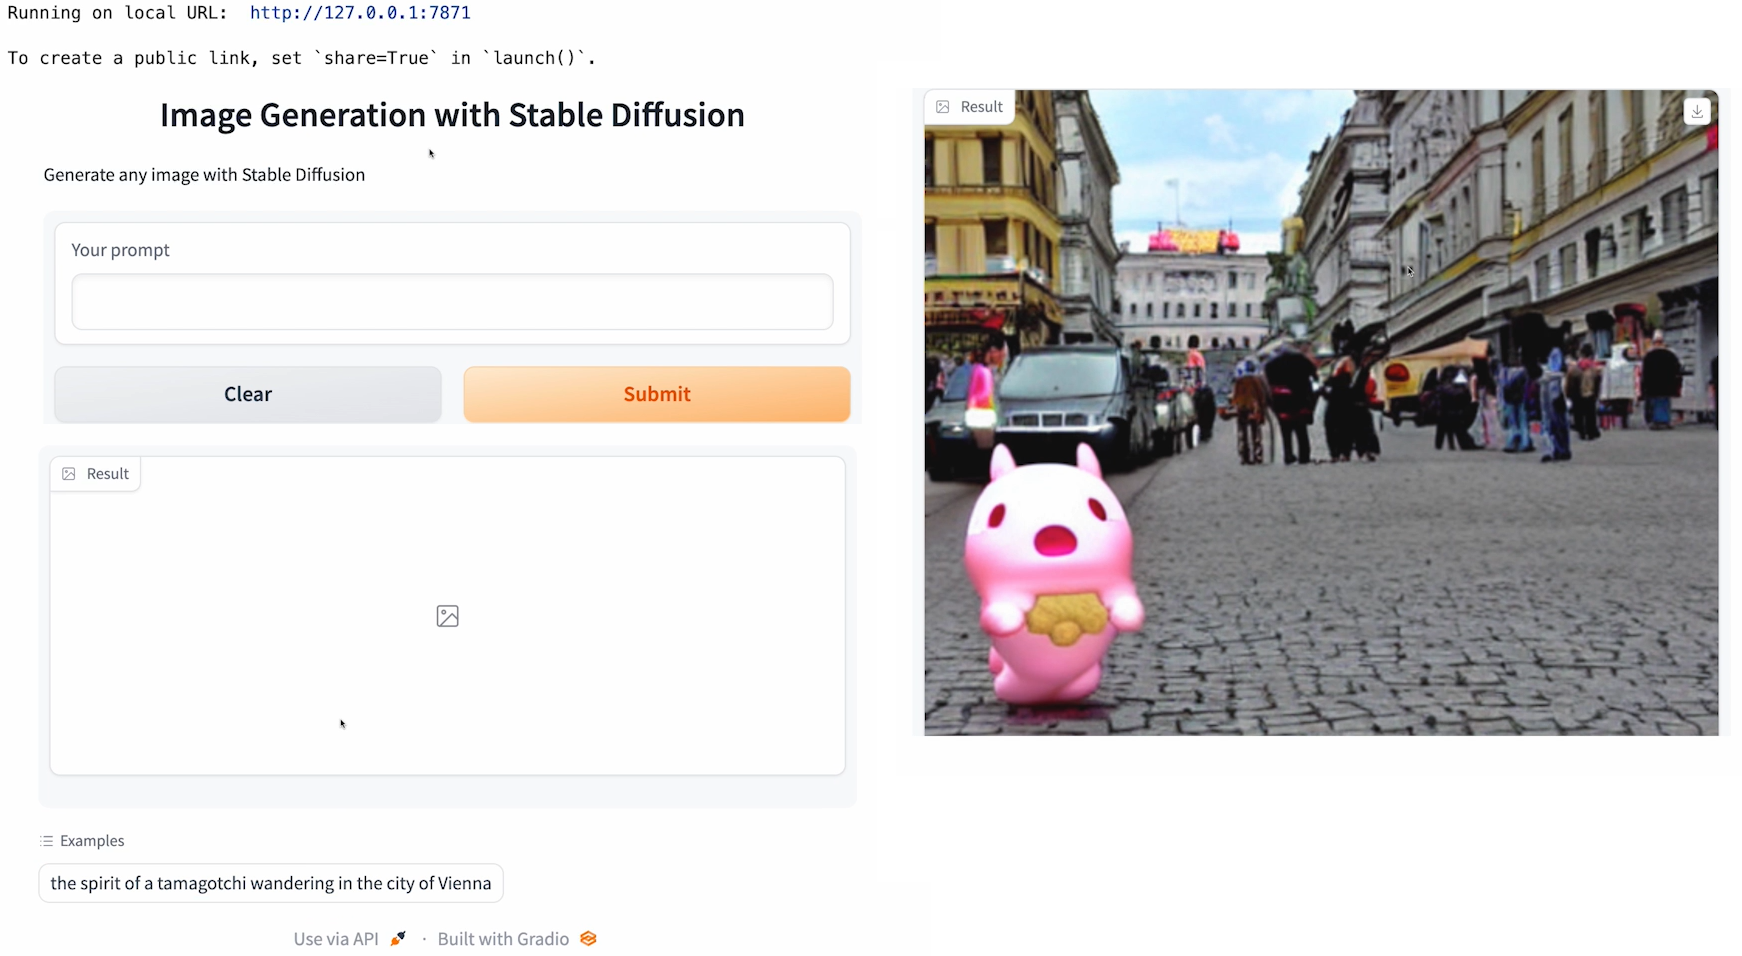

So here, we have our image generation app. As you can see, it's very similar to the previous lessons' app, but reversed. So, in the outputs, we have the image component and in the inputs, we have the text component. And as you can see, when the image is in the output component, it displays an image. And when an image is in the input's component, it prompts you to upload an image. So here, we can type any sentence that we like.

So here, for example, we have this example, the spirit of a Tamagotchi wandering the city of Vienna, kind of a complex prompt. And I actually live in Vienna, which ranks first as the most livable city in the world. It's super walkable and has a great public transportation. And if you remember Tamagotchis were those little virtual pets on the 90s. So, you can kind of see like this little Tamagotchi, and then the background, you'll see the city of Vienna.

And every time you run the function to generate an image, it generates a new image. So, with the same prompt, you already have infinite fun if you want to keep generating images. And of course, you can also vary, here you have a very weird ghost, but we ask for a spirit anyways. So, feel free to experiment with whatever your imagination comes up with. If you cannot think of anything, you can look around in the room you're at and maybe try to describe some objects, try to describe some fun memories you had. Here, for example, I'm in a room and I actually just ate, so I will put something like in an empty box with some chopsticks at the side of a laptop. I don't even know if that's gonna work, but let's see. Let's try it out together. Yeah, kind of had the empty box with this chopstick. The laptop, it completely forgot. But yeah, those models are still not perfect and they don't follow the prompt fully. So, it requires some experimentation for the prompting, but I encourage you to experiment and play a bit with this app.


In [ ]:
demo.close()

## Building a more advanced interface

Stable Diffusion is a powerful model, and it has a few more parameters. So, we have our negative prompt, the inference steps, our guidance scale, and the width and height of this image. So, let's go back to our UI to understand what's going on.

In [ ]:
import gradio as gr 

#A helper function to convert the PIL image to base64 
# so you can send it to the API
def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt, negative_prompt, steps, guidance, width, height):
    params = {
        "negative_prompt": negative_prompt,
        "num_inference_steps": steps,
        "guidance_scale": guidance,
        "width": width,
        "height": height
    }
    
    output = get_completion(prompt, params)
    pil_image = base64_to_pil(output)
    return pil_image

gr.close_all()
demo = gr.Interface(fn=generate,
                    inputs=[
                        gr.Textbox(label="Your prompt"),
                        gr.Textbox(label="Negative prompt"),
                        gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                                 info="In how many steps will the denoiser denoise the image?"),
                        gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7, 
                                  info="Controls how much the text prompt influences the result"),
                        gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512),
                        gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512),
                    ],
                    outputs=[gr.Image(label="Result")],
                    title="Image Generation with Stable Diffusion",
                    description="Generate any image with Stable Diffusion",
                    allow_flagging="never"
                    )

demo.launch(share=True, server_port=int(os.environ['PORT2']))

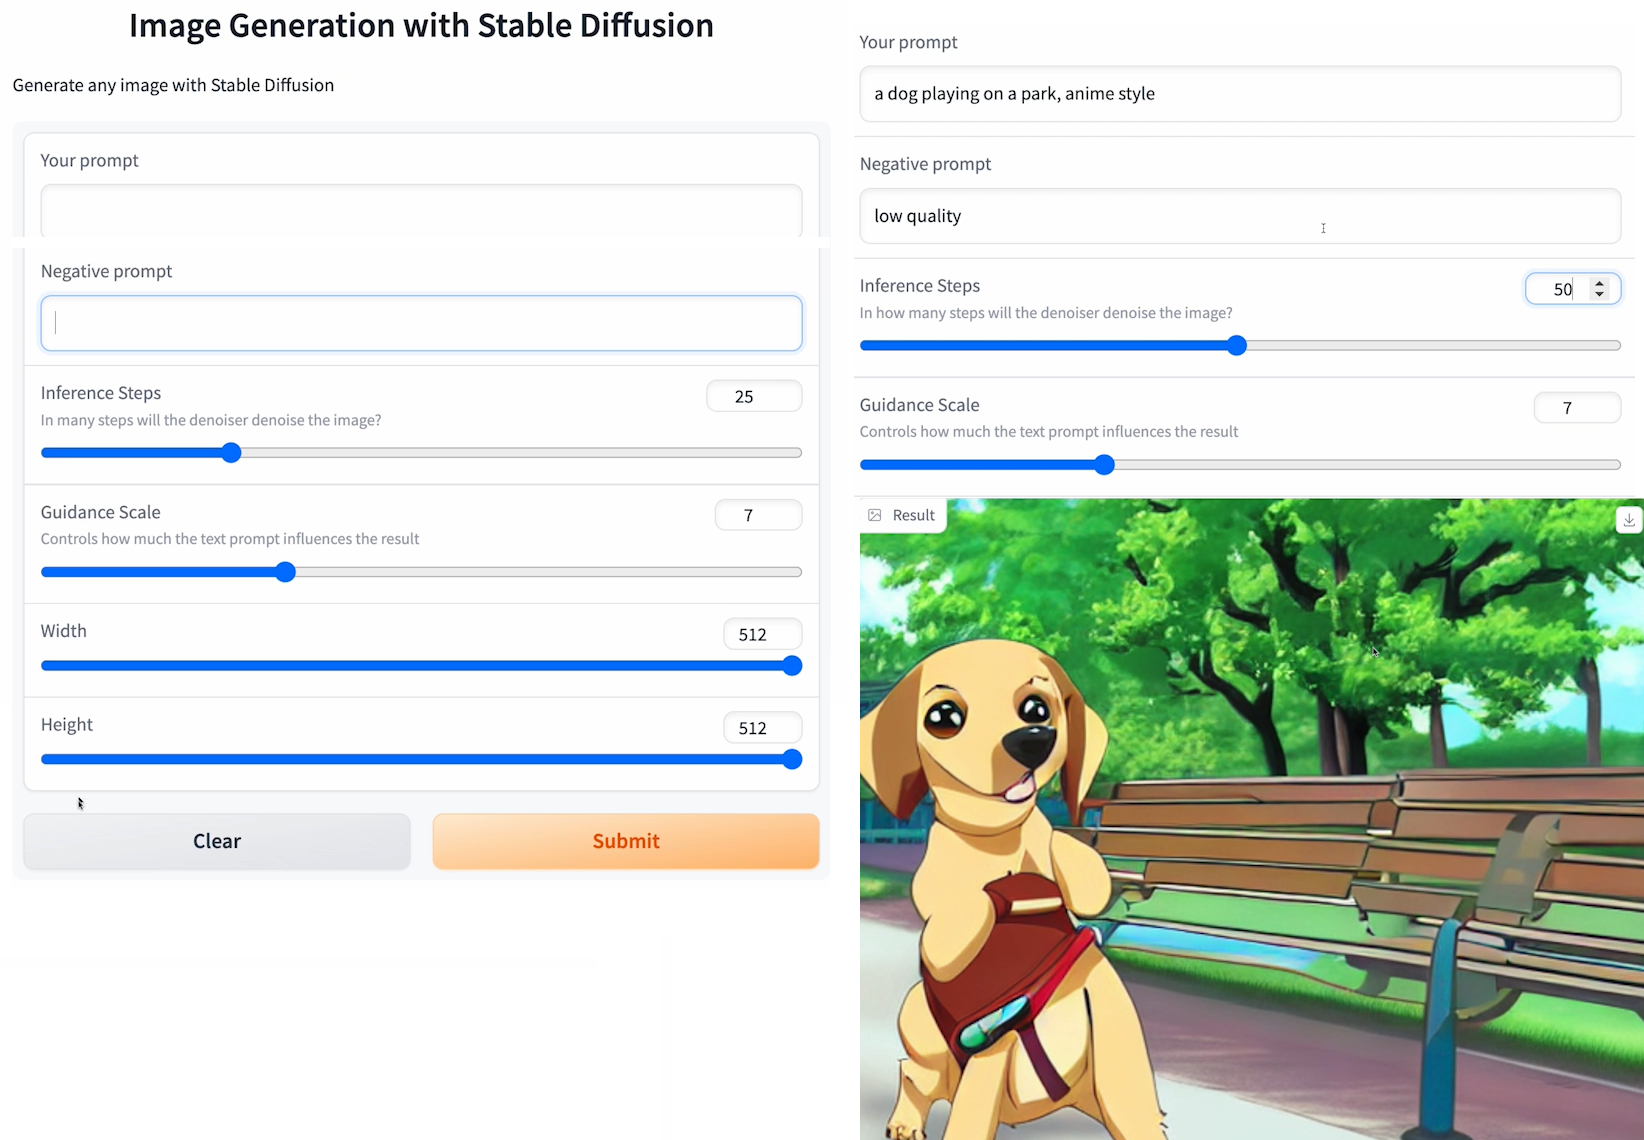

So here, we have two Gradio Textbox elements, which are elements that we had already seen before. We have a Gradio slider, which is an element that we hadn't seen yet. 

Okay, so let's try this more complete UI. So here, let's do a dog playing on a park. Animate style, and let's say I don't want low quality in my image. And surprisingly enough, if you type low quality as a negative prompt, it actually increases the quality because it will try to drive away from images that had low quality in their captions. I will increase a bit the number of inference steps, and then this will also increase the quality, but it will take a bit more time. And let's do this! Here, we have a dog, drawn in anime style. This face looks a bit strange, but it looks cute.

In [ ]:
demo.close()

## `gr.Blocks()` to the rescue!

Okay, so, we have an app that works and that has this more complex flares, but our user interface got a bit crowded. So, we can do something about that. And for that, we're going to introduce Gradio blocks. So, Gradioi Blocks are a different kind of interface. So, until now, we have been using this structure here called Gradio Interface, which essentially is a very streamlined way where we can do a function, the inputs, outputs, title, description, and it generates an app for us. While Gradio Blocks enable us to build a bit more complex user interfaces by essentially letting you build yourself your rows and columns and where to position elements in your app.

In [ ]:
# Create a Markdown block with the title "Image Generation with Stable Diffusion"
with gr.Blocks() as demo:
    gr.Markdown("# Image Generation with Stable Diffusion")

    # Create a text input box labeled "Your prompt"
    prompt = gr.Textbox(label="Your prompt")

    # Create a row containing two columns
    with gr.Row():

        # First column
        with gr.Column():
            
            # Create a text input box labeled "Negative prompt"
            negative_prompt = gr.Textbox(label="Negative prompt")
            
            # Create a slider labeled "Inference Steps" with specified minimum, maximum, default value, and info text
            steps = gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                              info="In how many steps will the denoiser denoise the image?")
            
            # Create a slider labeled "Guidance Scale" with specified minimum, maximum, default value, and info text
            guidance = gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7,
                                 info="Controls how much the text prompt influences the result")
            
            # Create a slider labeled "Width" with specified minimum, maximum, step, and default value
            width = gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512)
            
            # Create a slider labeled "Height" with specified minimum, maximum, step, and default value
            height = gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512)
            
            # Create a button labeled "Submit"
            btn = gr.Button("Submit")

        # Second column
        with gr.Column():
            
            # Create an image display block labeled "Result"
            output = gr.Image(label="Result")

    # Attach a click event handler to the "Submit" button, specifying input and output variables
    btn.click(fn=generate, inputs=[prompt, negative_prompt, steps, guidance, width, height], outputs=[output])

# Close all existing gradio blocks
gr.close_all()

# Launch the demo with sharing enabled on a specified server port (obtained from an environment variable)
demo.launch(share=True, server_port=int(os.environ['PORT3']))

So, Gradio interface makes it very easy to build. So here, we'll do with Gradio blocks as demo in the same way that we could have a Gradio title before. Here, we have a Gradio markdown that we can do whatever we'd like with the markdown. So here, we are doing a title, and we also have our prompt. But in Gradio block, if you want to use your elements as inputs or outputs, you'll have to attribute them to a variable. So here, we attribute the Gradio Textbox to the prompt variable. And here, we'll have the UI building element. So, we have the Gradio row, and here we will have two columns, so two Gradio columns. And there we have the same elements as we had before. So, we had the negative prompt, the steps, the guidance, the width, and the height, and a new Gradio button element that is our submit button.

And on the other column, we will have our output. And with Gradle Blocks, we have to explicitly denote what clicking our button does. So, while in Gradle Interface, you just have a function that the button will execute no matter what. In Gradle Blocks, we can define what clicking on this button will do. So here, we have button click, and then a function generate, which is the same generate function that we used before. So, we actually are not changing our generation function, we're just changing our user interface. The inputs are the same inputs as before. Now, instead of defining the elements right into the inputs, we call each variable that was attributed to each input and the variable also attributed to the output. In the same way as the interface, we run demo launch, and we should have our app.

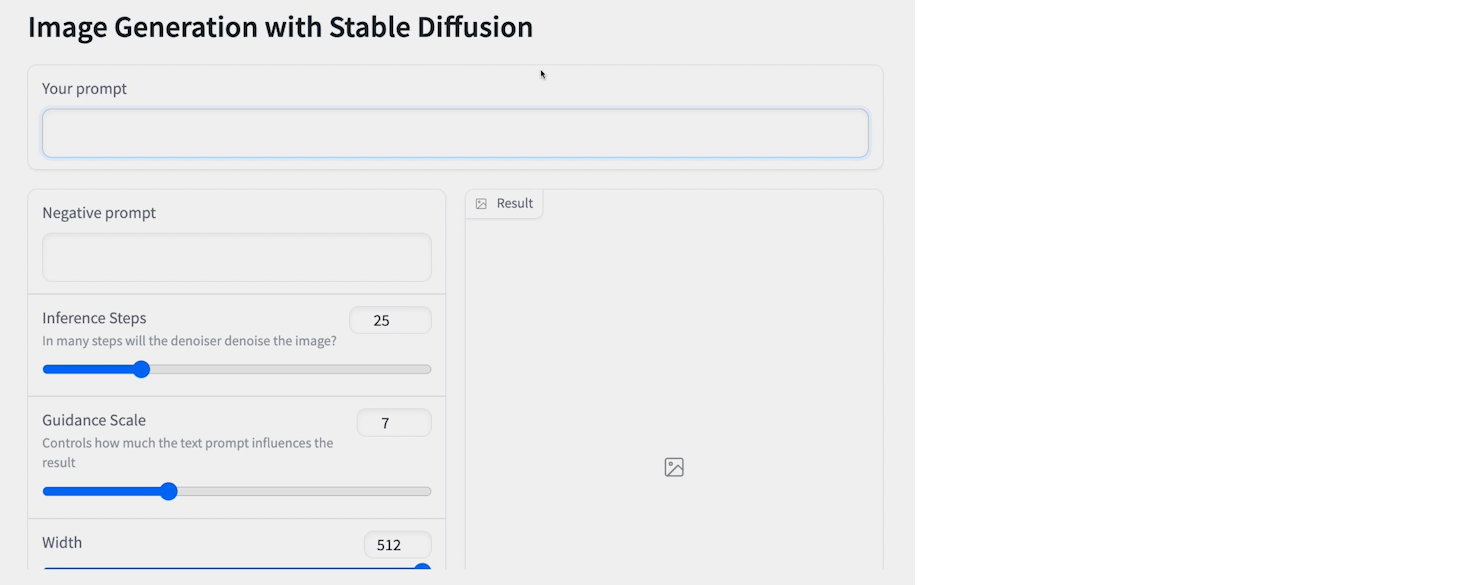

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# Image Generation with Stable Diffusion")
    with gr.Row():
        with gr.Column(scale=4):
            prompt = gr.Textbox(label="Your prompt") #Give prompt some real estate
        with gr.Column(scale=1, min_width=50):
            btn = gr.Button("Submit") #Submit button side by side!
    with gr.Accordion("Advanced options", open=False): #Let's hide the advanced options!
            negative_prompt = gr.Textbox(label="Negative prompt")
            with gr.Row():
                with gr.Column():
                    steps = gr.Slider(label="Inference Steps", minimum=1, maximum=100, value=25,
                      info="In many steps will the denoiser denoise the image?")
                    guidance = gr.Slider(label="Guidance Scale", minimum=1, maximum=20, value=7,
                      info="Controls how much the text prompt influences the result")
                with gr.Column():
                    width = gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512)
                    height = gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512)
    output = gr.Image(label="Result") #Move the output up too
            
    btn.click(fn=generate, inputs=[prompt,negative_prompt,steps,guidance,width,height], outputs=[output])

gr.close_all()
demo.launch(share=True, server_port=int(os.environ['PORT4']))

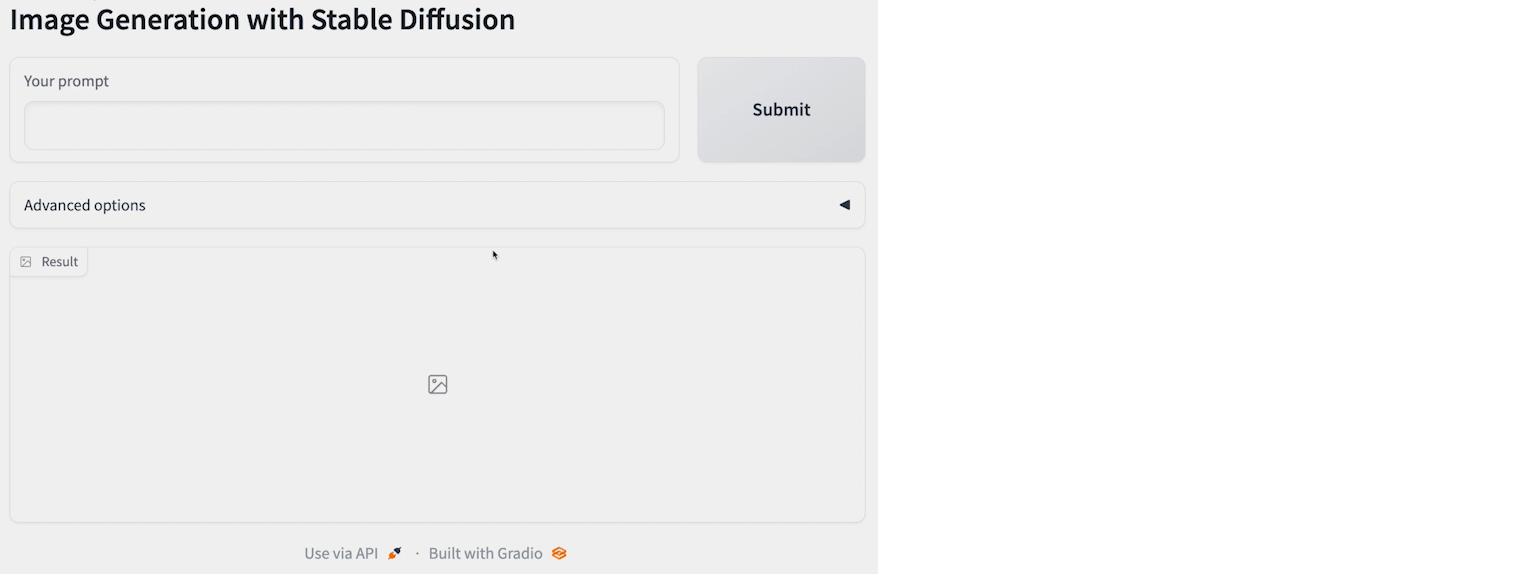

In our next example, I will show you how a UI could be a bit more complex to build. You can see that it's a bit convoluted. It has a lot of elements, but it is very simple to use. So, you have a prompt, a button, advanced options, and then the output. This is a bit of the trade-off that we have with Gradle Blocks that if you'd like to build a more simple UI, you may have to build a bit of more complex code and vice versa. So with Gradle interface, it's the simplest possible code, but the UI can get a bit complex and cluttered. So, let's see what's going on here. So here, we set a Gradle markdown for the title, and this is where we have. We have a Gradle row with two columns, one being the prompt and the other being the button right by it. We have a scale element. So, in the scale element, we divide up our element into the sum of chunks. 

So here, for example, because we have one column with scale four and one column with scale one, we have five chunks, and then the first element would take four parts of it, and the second element would take one part of it. But besides that, we can define that one element would not respect those chunks and in case we need to give it a minimum width. So, in this case, for example, I said that the button cannot get smaller than 50 pixels. Here we have another element that can simplify our UI, and that is the Gradle Accordion. So, if you have something like advanced options that we don't want to expose to every user, we can have an accordion that will essentially hide some information and that can be prompted when opened. So here, by default, the accordions are already open, so we have to define that they start closed. Here, we have a structure that inside of the accordion, we can also customize the elements in the way we would like. So here, we have the negative prompt because we want to give it a bit more real estate. So, we put the negative prompt taking this entire row, and then below it, we have a row with two columns being the inference steps and the guidance scale in one side and the width and height on the other side. And after it all, we have the result. So, we close the accordion, and we have a simple UI using radial blocks that can make your image generation application really easy to use.

In [ ]:
gr.close_all()